In [1]:
datasetName = 'brain_TemporalLobe_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_TemporalLobe_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AdultTemporalLobe_1.AAGCGGAAAACGTTGGAC,AdultTemporalLobe_1.AAGCGGTGAAGCAATAAA,AdultTemporalLobe_1.AACCTACGCTTGCCGACG,AdultTemporalLobe_1.AAGCGGGATCTTGATCTT,AdultTemporalLobe_1.CTCGCATTCCGCCGCTTG
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,7,8,1,4,7
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AdultTemporalLobe_1.AAGCGGAAAACGTTGGAC,brain,AdultTemporalLobe,AdultTemporalLobe,Intractable epilepsy,Donor52,female,61 years old
AdultTemporalLobe_1.AAGCGGTGAAGCAATAAA,brain,AdultTemporalLobe,AdultTemporalLobe,Intractable epilepsy,Donor52,female,61 years old
AdultTemporalLobe_1.AACCTACGCTTGCCGACG,brain,AdultTemporalLobe,AdultTemporalLobe,Intractable epilepsy,Donor52,female,61 years old
AdultTemporalLobe_1.AAGCGGGATCTTGATCTT,brain,AdultTemporalLobe,AdultTemporalLobe,Intractable epilepsy,Donor52,female,61 years old
AdultTemporalLobe_1.CTCGCATTCCGCCGCTTG,brain,AdultTemporalLobe,AdultTemporalLobe,Intractable epilepsy,Donor52,female,61 years old


[1] Oligodendrocyte Oligodendrocyte Oligodendrocyte Macrophage     
[5] Macrophage     
17 Levels: Antigen presenting cell (RPS high) Astrocyte ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


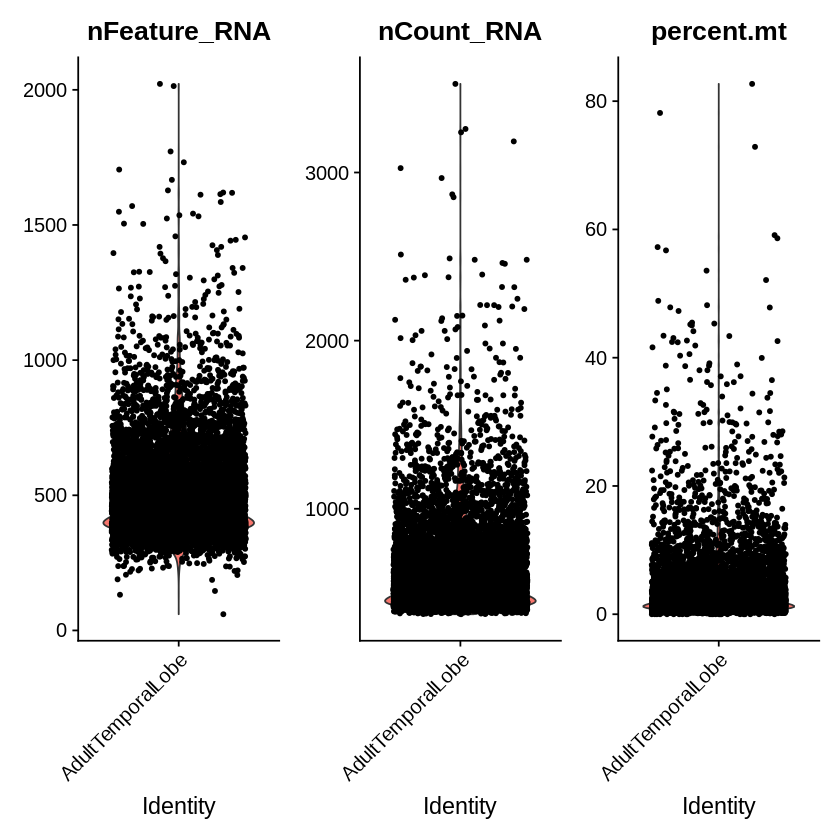

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [7]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  CRYAB, CNP, TF, APOD, APLP1, TUBA1A, PPP1R14A, GPRC5B, S100B, MBP 
	   GLUL, CLU, ATP1A2, NTM, TTYH1, CALM1, C1orf61, SPARCL1, PLPP3, PTN 
	   FAM134B, TUBB2B, DHCR24, ADIRF, CERCAM, ALDOC, LARP6, CLDN10, SLC6A1, SLCO1A2 
Negative:  CD74, HLA-DRB1, C1QB, C3, B2M, HLA-DRA, HLA-DPA1, FTL, CX3CR1, CD14 
	   TREM2, HSPA1A, TMSB10, SRGN, HSPA1B, CCL3, SAT1, CSF1R, GPR34, CCL4L2 
	   FOS, OLFML3, DUSP1, HLA-DRB6, CH25H, RGS10, FCGR3A, CCL4, CCL2, ITM2B 
PC_ 2 
Positive:  CRYAB, CNP, TF, APLP1, MBP, TUBA1A, PPP1R14A, APOD, GPRC5B, MT-ND3 
	   FAM134B, MT-ND2, SLCO1A2, DHCR24, LARP6, CERCAM, S1PR5, SFRP1, FAM13C, NKAIN2 
	   S100B, BTBD3, LRP2, SERINC5, DPYSL5, AZGP1, KCNMB4, CLCN4, HSD11B1, RP4-613B23.1 
Negative:  ATP1A2, CLU, SPARCL1, GJA1, AQP4, CLDN10, CXCL14, CST3, ATP1B2, SLC1A2 
	   GPM6A, CPE, SCG3, SERPINE2, ALDOC, MGST1, AGT, TSPAN7, DKK3, CHI3L1 
	   ETNPPL, F3, GJB6, SLC39A12, ITM2C, BCAN, MT1G, NTRK2, C1orf61, TUBB2B 
PC_ 3 
Positive:  MYL9, TPM2, TAGLN, ACTA2, 

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


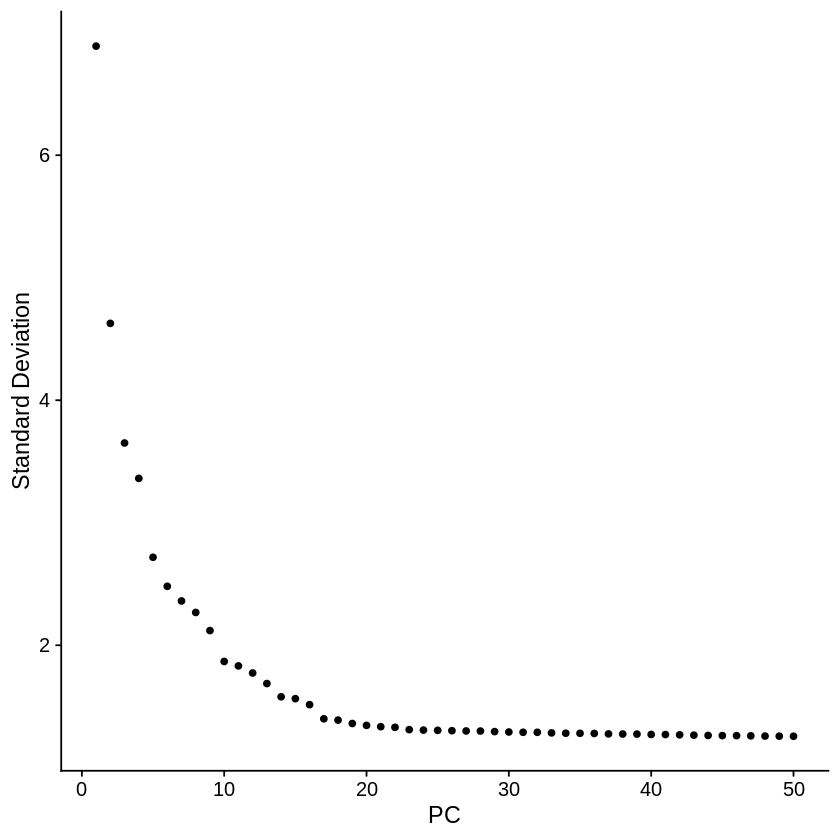

In [8]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [9]:
dev.off()
pcDim = 20 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
03:08:43 UMAP embedding parameters a = 0.9922 b = 1.112

03:08:43 Read 9692 rows and found 20 numeric columns

03:08:43 Using Annoy for neighbor search, n_neighbors = 30

03:08:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:08:44 Writing NN index file to temp file /tmp/RtmpB8svhV/file100f5a2f0041

03:08:44 Searching Annoy index using 1 thread, search_k = 3000

03:08:48 Annoy recall = 100%

03:08:48 Commencing smooth kNN distance calibration using 1 thread

03:08:49 Initializing fr

In [10]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9692
Number of edges: 338911

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8671
Number of communities: 15
Elapsed time: 1 seconds


03:09:16 UMAP embedding parameters a = 0.9922 b = 1.112

03:09:16 Read 9692 rows and found 20 numeric columns

03:09:16 Using Annoy for neighbor search, n_neighbors = 30

03:09:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:09:18 Writing NN index file to temp file /tmp/RtmpB8svhV/file100f2b7ab23f

03:09:18 Searching Annoy index using 1 thread, search_k = 3000

03:09:22 Annoy recall = 100%

03:09:22 Commencing smooth kNN distance calibration using 1 thread

03:09:23 Initializing from normalized Laplacian + noise

03:09:24 Commencing optimization for 500 epochs, with 439928 positive edges

03:09:50 Optimization finished



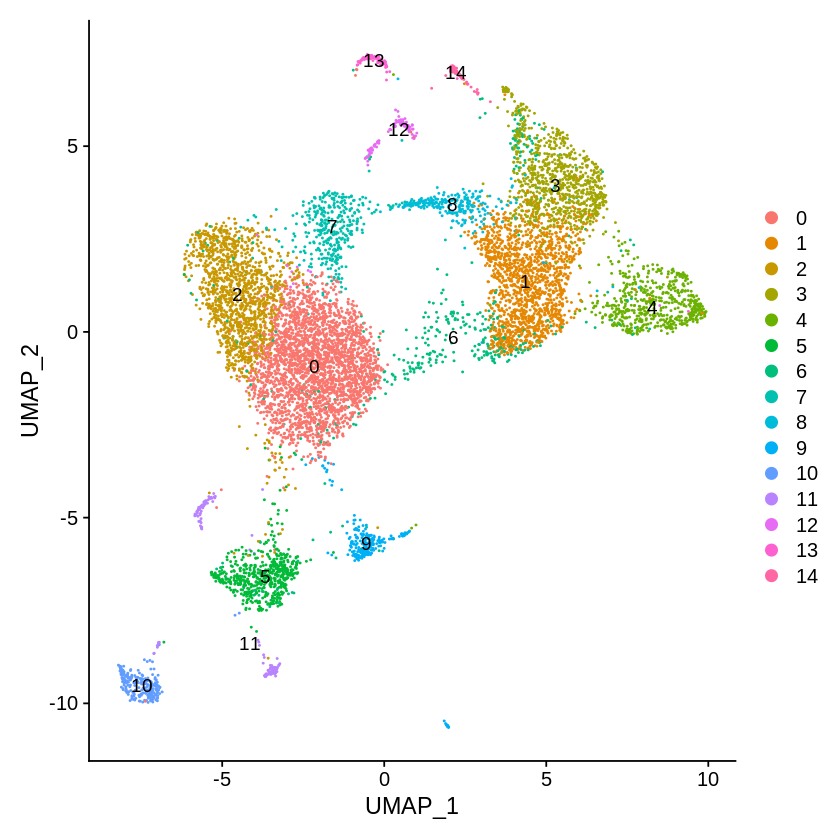

In [17]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [20]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

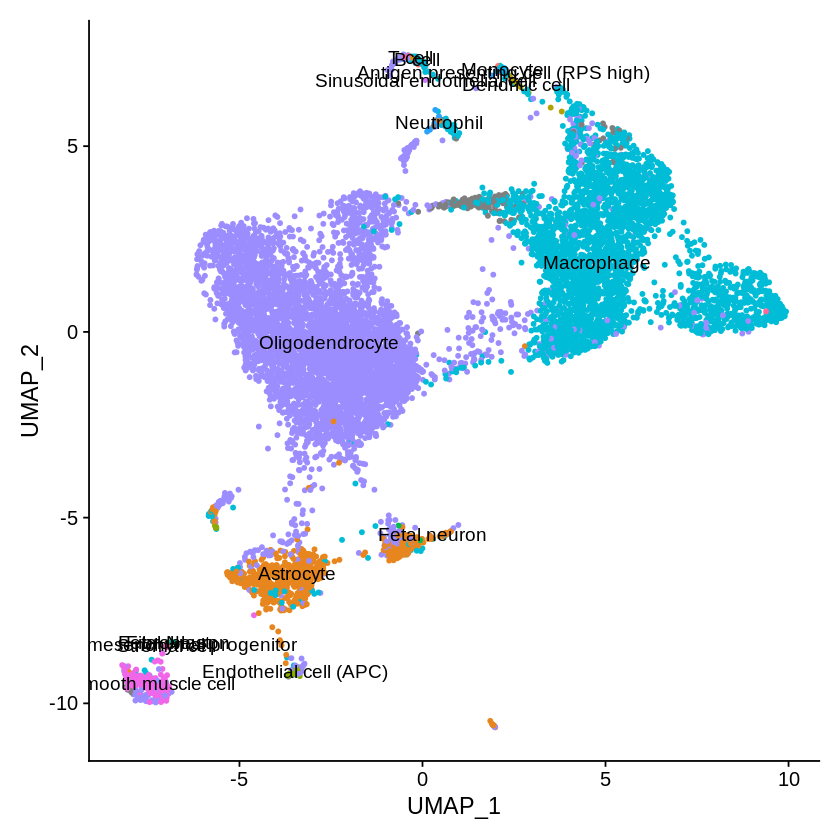

In [18]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [21]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [19]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [22]:
new.cluster.ids <- c('Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Connective Tissue-Macrophage-CD14', 'Brain-Nerve tissue-Oligodendrocyte-MBP',
                    'Brain-Connective Tissue-Macrophage-CD14', 'Brain-Connective Tissue-Macrophage-CD14', 'Brain-Nerve tissue-Astrocyte-ALDOC',
                     'Unknown', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Connective Tissue-Macrophage-CD14',
                    'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Muscle tissue-Smooth muscle cell-TAGLN', 'Brain-Epithelial tissue-Endothelial cell-CLDN5',
                    'Brain-Connective tissue-Neutrophil-S100A8', 'Brain-Connective tissue-T cell-TRBC2', 'Brain-Connective Tissue-Macrophage/Neutrophil-CD14 and S100A8')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [11]:
# 给Unknown
new.cluster.ids <- c('Brain-Nerve tissue-Oligodendrocyte-MBP', 'Unknown', 'Brain-Nerve tissue-Oligodendrocyte-MBP',
                    'Unknown', 'Unknown', 'Brain-Nerve tissue-Astrocyte-ALDOC',
                     'Unknown', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Unknown',
                    'Brain-Nerve tissue-Astrocyte-ALDOC', 'Unknown', 'Brain-Epithelial tissue-Endothelial cell-CLDN5',
                    'Unknown', 'Unknown', 'Unknown')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

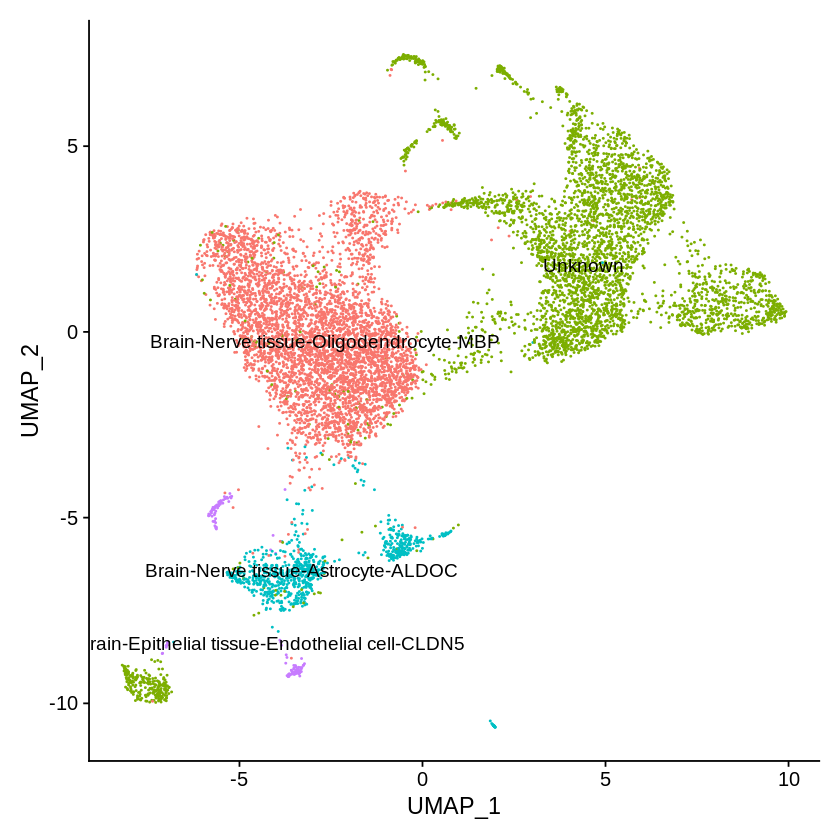

In [12]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [13]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [14]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))